In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from cyvcf2 import VCF
from collections import defaultdict
import math
from scipy.stats.stats import pearsonr
from sklearn.metrics import r2_score
import seaborn as sns

In [2]:
pops = ['AFR', 'EUR', 'EAS', 'AMR', 'SAS']

def compare(gts, imp):
    gts = gts.replace("(", "")
    gts = gts.replace(")", "")
    imp = imp.replace(")", "")
    imp = imp.replace("(", "")
    gts = gts.split(",")
    imp = imp.split(",")
    gts = [int(gt) for gt in gts]
    imp = [int(im) for im in imp]
    gts.sort()
    imp.sort() 
    if gts == imp:
        return 1
    if gts[0] in imp or gts[1] in imp:
        return 0.5
    return 0


def calc_concordance(imputed_df, genotype_df):
    concordance = []
    for i in range(len(imputed_df)):
        n = 100
        gts = list(genotype_df.iloc[i])
        imputes = list(imputed_df.iloc[i])
        sum_11 = 0
        if gts[0] != imputes[0]:
            print("shit", gts[0])
        for j in range(1,n+1):
            if (type(gts[j]) == float and math.isnan(gts[j])) or (type(imputes[j]) == float and math.isnan(imputes[j])):
                n -= 1
                continue
            sum_11 += compare(gts[j],imputes[j])
        concordance.append([chrom,gts[0],sum_11/n])
    return concordance

def calc_r2(imputed_df, genotype_df):
    correlation = []
    for i in range(len(imputed_df)):
        n = 100
        gts = list(genotype_df.iloc[i])
        imputes = list(imputed_df.iloc[i])
        sum_11 = 0
        if gts[0] != imputes[0]:
            print("Positions are not match", gts[0])
            
        gts_vector = []
        imputed_vector = []
        
        for j in range(1,n+1):
            if (type(gts[j]) == float and math.isnan(gts[j])) or (type(imputes[j]) == float and math.isnan(imputes[j])):
                continue
            vec = gts[j].replace("(","").replace(")","").split(",")
            gts_vector.extend([int(x) for x in vec])
            
            vec = imputes[j].replace("(","").replace(")","").split(",")
            imputed_vector.extend([int(x) for x in vec])
        
        pearson = pearsonr(gts_vector, imputed_vector)[0]
        if np.isnan(pearson):
            correlation.append((gts[0], r2_score(gts_vector, imputed_vector)))
        else:
            correlation.append((gts[0], pearson**2))
    return correlation


chrom=21
concordance = []
r2 = []
for pop in pops:
    imputed = pd.read_csv(f"/expanse/projects/gymreklab/helia/ensembl/biallelic/validation/diff_{pop}/{chrom}/imputed.csv", sep = ",")
    genotypes = pd.read_csv(f"/expanse/projects/gymreklab/helia/ensembl/biallelic/validation/diff_{pop}/{chrom}/genotypes.csv", sep = ",")
    concordance.append(calc_concordance(imputed, genotypes))
    #r2.append(calc_r2(imputed, genotypes))
        


In [12]:
print("AFR_100k", np.array([x[2] for x in calc_concordance(imputed_AFR_100k, genotypes_AFR_100k)]).mean())
print("EUR_100k", np.array([x[2] for x in calc_concordance(imputed_EUR_100k, genotypes_EUR_100k)]).mean())

AFR 0.928633201845638
EUR 0.963734049537536
AFR_100k 0.9260774911477894
EUR_100k 0.9570904243750459


In [4]:
for i in range(5):
    pop = pops[i]
    print(f"{pop}", np.array([x[2] for x in concordance[i]]).mean())


AFR 0.9275782536514382
EUR 0.9633366962832036
EAS 0.9534699480441574
AMR 0.9630653077988173
SAS 0.9582312082636877


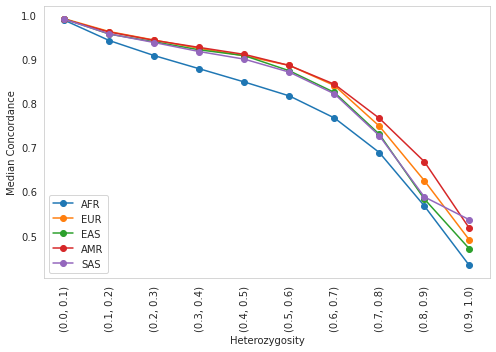

In [79]:
### Concordance plot ###

fig, ax = plt.subplots(figsize=(7, 5))
keys = []
for i in range(10):
    keys.append((i/10,(i+1)/10))
for i in range(len(pops)):
    pop = pops[i]
    
    stats = pd.read_csv(f"/expanse/projects/gymreklab/helia/ensembl/experiments/allele_freq/freqs/freqs_chr21_{pop}.tab", 
                        sep = "\t")
    stats['chrom'] = stats['chrom'].astype(str)


    df = pd.DataFrame(concordance[i],columns =['chrom', 'start', 'score'])
    df['chrom'] = 'chr' + df['chrom'].astype(str)
    stats_scores = pd.merge(stats, df, on = ['chrom','start'])
    
    het_dict = {}
    for i in range(10):
        het_dict[i] = []
        
    for index,row in stats_scores.iterrows():
        if len(row['afreq-1'].split(",")) == 1:
            continue
        het_dict[int(row['het-1'] * 10)].append(row['score'])
        
    for key in het_dict:
        het_dict[key] = np.mean(het_dict[key])
           
    ax.plot(het_dict.keys(), het_dict.values(), marker= "o", label = pop)
    
ax.xaxis.set_ticks(np.arange(0, 10, 1))
ax.set_xticklabels(keys,rotation='vertical')
ax.set_xlabel("Heterozygosity")
ax.set_ylabel("Median Concordance")
ax.legend(loc="lower left")  
fig.tight_layout()
plt.savefig("Heterozygosity_vc_score.pdf", dpi=1200)

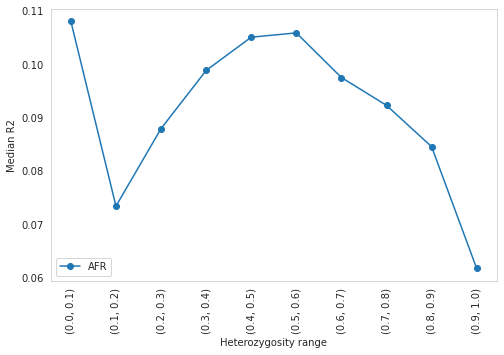

In [75]:
fig, ax = plt.subplots(figsize=(8, 5))
keys = []
for i in range(10):
    keys.append((i/10,(i+1)/10))
for i in range(len(pops)):
    pop = pops[i]
    
    stats = pd.read_csv(f"/expanse/projects/gymreklab/helia/ensembl/experiments/allele_freq/freqs/freqs_chr21_{pop}.tab", 
                        sep = "\t")
    stats['chrom'] = stats['chrom'].astype(str)


    df = pd.DataFrame(r2[i],columns =['start', 'score'])
    df['chrom'] = 'chr21'
    stats_scores = pd.merge(stats, df, on = ['chrom','start'])
    
    het_dict = {}
    for i in range(10):
        het_dict[i] = []
        
    for index,row in stats_scores.iterrows():
        if len(row['afreq-1'].split(",")) == 1:
            continue
        het_dict[int(row['het-1'] * 10)].append(row['score'])
        
    for key in het_dict:
        het_dict[key] = np.nanmedian(het_dict[key])
      
#     ax.boxplot(het_dict.values())
#     ax.set_xticklabels(np.arange(0, 10, 1),rotation='vertical')
#     ax.set_ylabel("Concordance")
#     ax.set_xlabel("Heterozygosity\")\n",
#     #display(list(het_dict.values()))\n",
#     \n",
#     sns.set(rc={'figure.figsize':(12,8)},font_scale = 1.4)\n",
#     sns.set_style("whitegrid", {'axes.grid' : False})
    ax.plot(het_dict.keys(), het_dict.values(), marker= "o", label = pop)
    break
    
ax.xaxis.set_ticks(np.arange(0, 10, 1))
ax.set_xticklabels(keys,rotation='vertical')
ax.set_xlabel("Heterozygosity range")
ax.set_ylabel("Median R2")
ax.legend(loc="lower left")  
# plt.savefig("Heterozygosity_vc_r2.pdf", dpi=1200)

In [73]:
r2[0]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 (13998484, 0.0374909673122973),
 1.0,
 1.0,
 1.0,
 1.0,
 (14070130, 0.16063710389951677),
 (14077443, 0.0799847786247495),
 1.0,
 (14079985, 0.019613587140142406),
 1.0,
 (14081508, 0.13312825310018964),
 (14081510, 0.13664202668151398),
 1.0,
 (14082833, 0.19593908629441537),
 1.0,
 (14106743, 0.16470306662129192),
 (14110338, 0.17729666771631175),
 (14110852, 0.04242471463633129),
 1.0,
 (14114178, 0.086996032216614),
 (14116010, 0.11086475121850162),
 1.0,
 (14116434, 2.525188757859686e-05),
 (14124994, 0.02047638634409005),
 (14125540, 0.08575051395794843),
 (14129799, 0.10292970944141669),
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 (14133013, 0.01833966321677928),
 1.0,
 0.0,
 1.0,
 (14141387, 0.16879151262368297),
 (14141628, 0.09533011956083251),
 1.0,
 1.0,
 (14146287, 0.0246471582798039),
 (14152072, 0.04087841609178245),
 (14152752, 0.0003107842121620207),
 1.0,
 (14158582, 0.0850645624103302),
 1.0,
 1.0,
 (14163093, 0.19392726729323387),
 1.0,